In [2]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

img = Image.open("cat.jpg")
inputs = transform(img)
inputs = inputs.unsqueeze(0)
#plt.imshow(inputs[0].permute(1,2,0))
#copy_inputs = copy.deepcopy(inputs)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model


In [3]:
output = model(inputs)

block_outputs = []
block_outputs_exchanged = []
#ブロックの入出力の抽出
for i in model.blocks:
    _output = i.block_output
    block_outputs.append(_output)
    block_outputs_exchanged.append(exchange.exchange_tensor_to_array(_output))

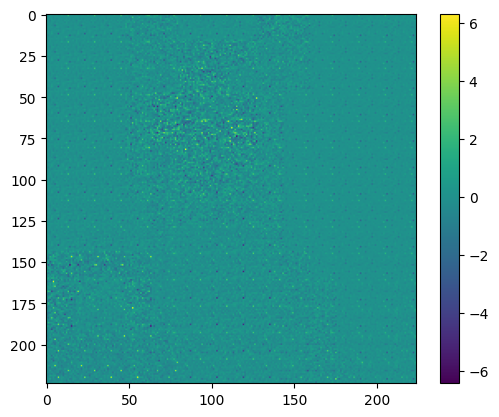

In [11]:
exchange.show_heatmap_with_colorbar(block_outputs_exchanged[0])

In [9]:
tmp = copy.deepcopy(block_outputs_exchanged[0])

829


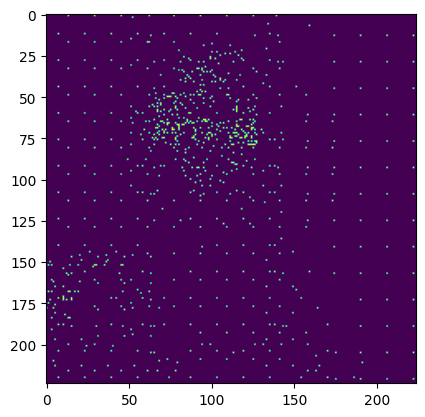

In [11]:
count = 0
for i in range(224):
    for j in range(224):
        if abs(tmp[i, j]) > 0:
            tmp[i, j] = 255
            count += 1
        else:
            tmp[i, j] = 0
print(count)
plt.imshow(tmp)

In [55]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3)
x = np.where(tmp > 0)
l = len(x[0])
p = [ [x[0][i], x[1][i]] for i in range(l)]
kmeans_model.fit(p)


KMeans(n_clusters=3)

In [56]:
clusters = kmeans_model.predict(p)

In [57]:
result = np.zeros((224, 224))
for i in range(l):
    y, x = p[i]
    result[y, x] = 255 * (clusters[i] + 1)

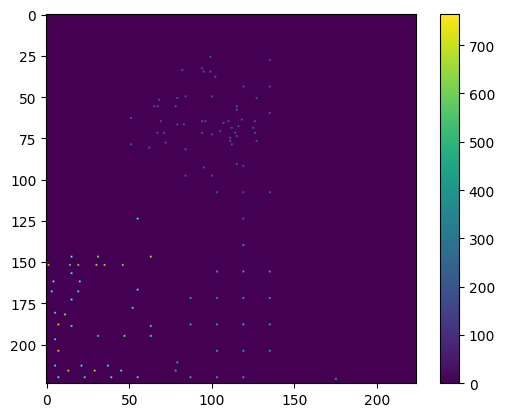

In [58]:
exchange.show_heatmap_with_colorbar(result)

In [67]:
def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json") as f:
        data = json.load(f)
        return [x["ja"] for x in data]

class_names = get_classes()
def base_model_output(_input : torch.Tensor) -> tuple:
    """画像をモデルに入力した際の一番スコアが高いラベルとそのスコアを返す"""
    base_output = model(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

    return (class_names[batch_indices[0][0]], batch_probs[0][0])


target_class_name, base_probs = base_model_output(inputs)
class_index = class_names.index(target_class_name)

In [75]:
base_probs

tensor(0.8991, grad_fn=<SelectBackward0>)

In [68]:
class_index

285

In [1]:
import collections
dd = collections.defaultdict(lambda : [])
for i in range(l):
    y, x = p[i]
    c = clusters[i]
    dd[c].append([y, x])
values = np.zeros((224, 224))
stack = collections.defaultdict(lambda : 0)
for i in dd.values()[1:]:
    for y, x in i:
        stack[(y, x, 0)] = inputs[0, 0, y, x].item()
        stack[(y, x, 1)] = inputs[0, 1, y, x].item()
        stack[(y, x, 2)] = inputs[0, 2, y, x].item()
        inputs[0, 0, y, x] = 0
        inputs[0, 1, y, x] = 0
        inputs[0, 2, y, x] = 0
    plt.imshow(inputs[0].permute(1,2,0))
    exit()
    tmp_output = model(inputs)
    batch_probs = F.softmax(output, dim=1)
    tmp_prob = batch_probs[0][class_index].item()
    tmp_value = tmp_prob - base_probs
    print(tmp_prob)
    for y, x in i:
        values[y, x] = tmp_value
        r, b, g = stack[(y, x, 0)], stack[(y, x, 1)], stack[(y, x, 2)]
        inputs[0, 0, y, x] = r
        inputs[0, 1, y, x] = b
        inputs[0, 2, y, x] = g
plt.imshow(inputs[0].permute(1,2,0))

NameError: name 'l' is not defined

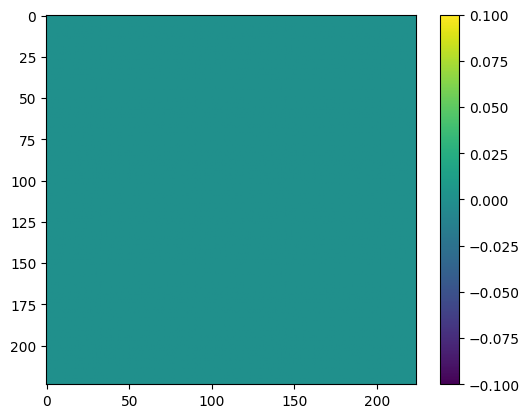

In [72]:
exchange.show_heatmap_with_colorbar(values)

<AxesSubplot: xlabel='x', ylabel='y'>

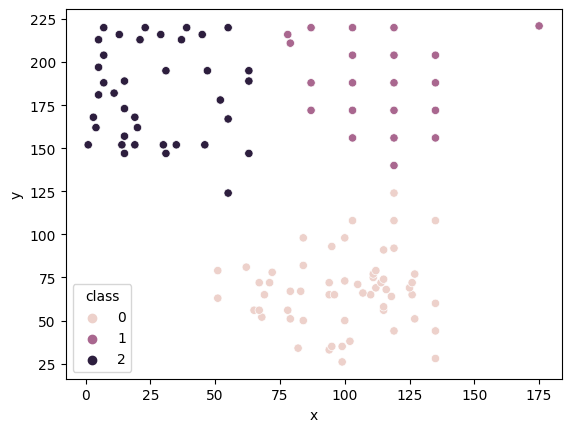

In [59]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(p, columns=["y", "x"])
df["class"] = clusters
sns.scatterplot(data=df, x="x", y="y",hue="class")